# Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib
from matplotlib import image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image

from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D,Activation,GlobalAveragePooling2D
from keras.optimizers import SGD,Adam
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionV3, ResNet50

# Loading the Dataset

In [36]:
import os
import zipfile
import shutil

# Paths for the dataset zip and extraction folder
dataset_zip = "PlantVillage.zip"
dataset_path = "PlantVillage"

# Unzipping the dataset
if not os.path.exists(dataset_path):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall()

    # Check if an extra "PlantVillage/PlantVillage" folder was created
    nested_folder = os.path.join(dataset_path, "PlantVillage")

    if os.path.exists(nested_folder):  
        # Move files from nested folder to the correct location
        for item in os.listdir(nested_folder):
            shutil.move(os.path.join(nested_folder, item), dataset_path)

        # Remove the empty nested folder
        os.rmdir(nested_folder)

In [37]:
# List all classes in the dataset
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print("Plant Village Classes:")
for plant_class in classes:
    print(f" - {plant_class}")


Plant Village Classes:
 - Pepper__bell___Bacterial_spot
 - Pepper__bell___healthy
 - Potato___Early_blight
 - Potato___healthy
 - Potato___Late_blight
 - Tomato_Bacterial_spot
 - Tomato_Early_blight
 - Tomato_healthy
 - Tomato_Late_blight
 - Tomato_Leaf_Mold
 - Tomato_Septoria_leaf_spot
 - Tomato_Spider_mites_Two_spotted_spider_mite
 - Tomato__Target_Spot
 - Tomato__Tomato_mosaic_virus
 - Tomato__Tomato_YellowLeaf__Curl_Virus


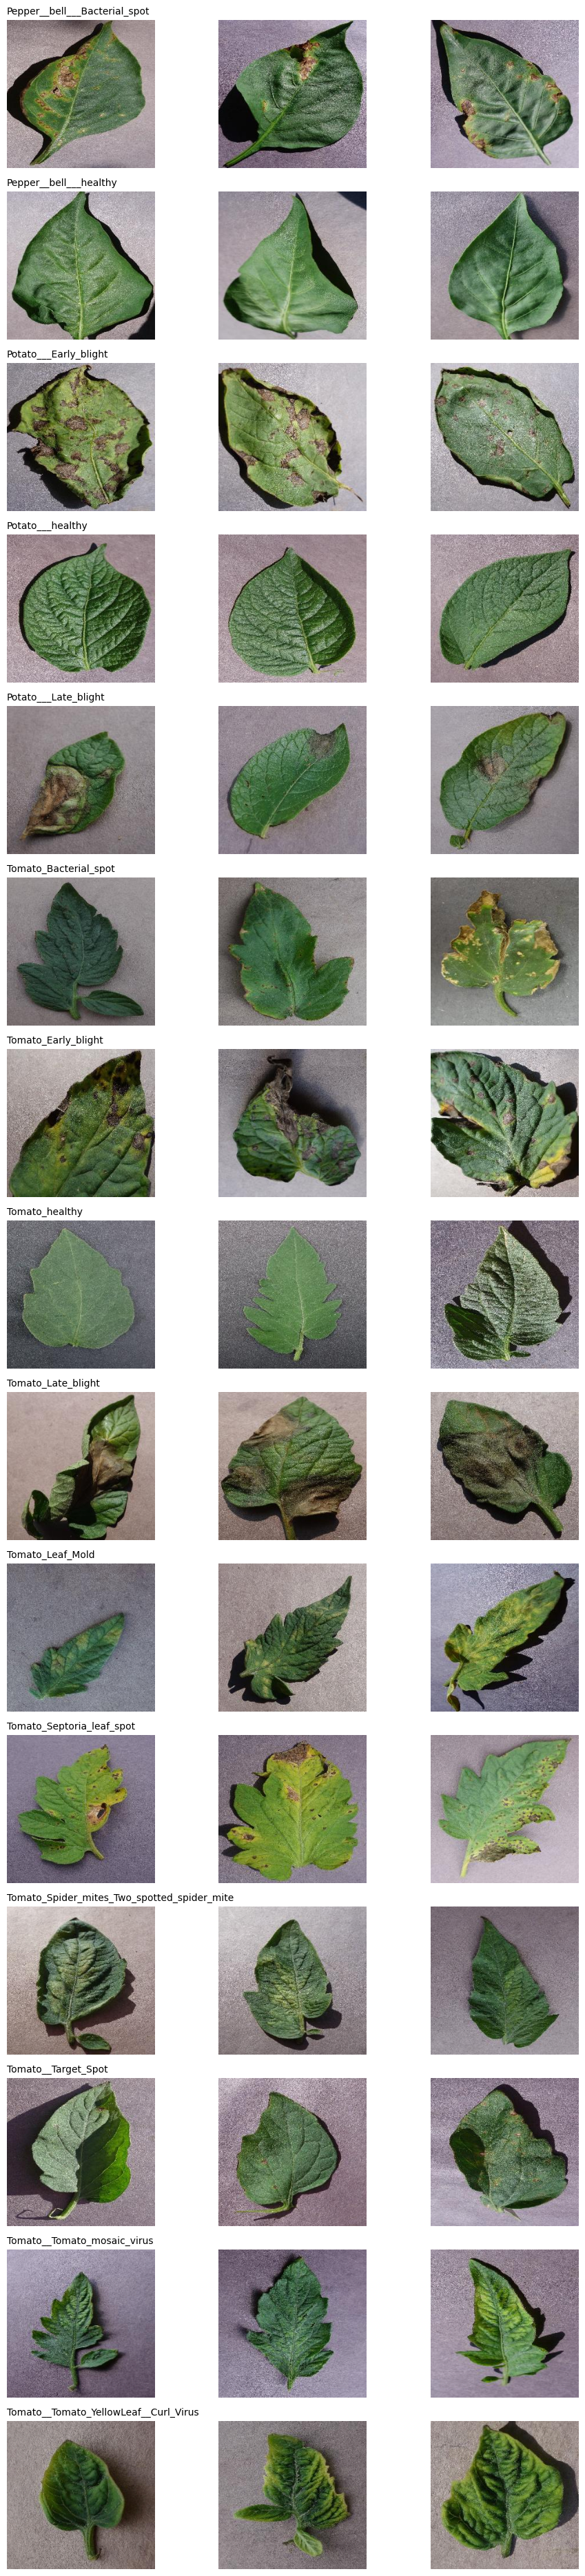

In [38]:

# Function to display sample images from each class
def display_images(dataset_path, num_images=3):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(10, len(classes) * 2.5))

    for i, plant_class in enumerate(classes):
        class_path = os.path.join(dataset_path, plant_class)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png','.JPG'))][:num_images]  # Get first few images

        for j, image_file in enumerate(image_files):
            img_path = os.path.join(class_path, image_file)
            img = Image.open(img_path)

            # Display image
            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_title(plant_class, fontsize=10, loc='left')  # Add class name as title

    plt.tight_layout()
    plt.show()

# Display images from each class
display_images(dataset_path)

# Splitting Data into Train & Test

In [39]:
from sklearn.model_selection import train_test_split

# Paths for train and test directories
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class names (subdirectories)
class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Split data for each class
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create class directories for train and test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move files to train and test directories
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


# Data Augmentation

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Image data generators for train and test sets
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode="categorical")
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode="categorical")


Found 14227 images belonging to 1 classes.
Found 6411 images belonging to 12 classes.


In [45]:
print("Train Generator Classes:", train_generator.class_indices)
print("Test Generator Classes:", test_generator.class_indices)


Train Generator Classes: {'train': 0}
Test Generator Classes: {'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Leaf_Mold': 3, 'Tomato_Septoria_leaf_spot': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato__Target_Spot': 6, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7, 'Tomato__Tomato_mosaic_virus': 8, 'Tomato_healthy': 9, 'test': 10, 'train': 11}


In [46]:

print("Train Directory:", os.listdir(train_dir))  # Should list class names, NOT "train"
print("Test Directory:", os.listdir(test_dir)) 

Train Directory: ['train']
Test Directory: ['test', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'train']
